<a href="https://colab.research.google.com/github/ranitha84/generative-adversial-network/blob/main/Cycle_GAN_Implementation_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pipeline
Steps Involved


1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF of Generated Images


### Importing Libraries


Important Libraries and their versions
*   numpy - 1.19.2
*   tensorflow - 2.4.1
*   matplotlib - 3.3.2
*   skimage - 0.17.2

In [ ]:
#Importing necessary Libraries.
import tensorflow as tf
import matplotlib.pyplot as plt
import glob # to find certain directories
import imageio
from IPython import display
from skimage.transform import resize
import numpy as np
import os # to access the folders and files
from keras.utils.vis_utils import plot_model

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

In [ ]:
(train_data, train_labels), (test_data, test_labels)= tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


#### Deciding the batch size

In [ ]:
BATCH_SIZE=1024

In [ ]:
train_data[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

#### Data Visualization of Images of 4 and 9

In [ ]:
img4 = train_data[train_labels==4]

img4= (img4/127.5)-1.0

img4.shape



(5842, 28, 28)

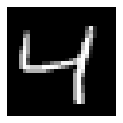

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(img4[0],cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img9 = train_data[train_labels==9]

img9= (img9/127.5)-1.0

img9.shape

(5949, 28, 28)

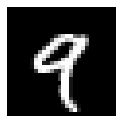

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(img9[0],cmap='gray')
plt.axis('off')
plt.show()

### Data Preprocessing

1.   Resize Images
2.   Reshape Images
3.   Shuffle Data


#### Resize Images to size (32, 32)


In [ ]:
dataset_digit4 = np.zeros([img4.shape[0],32,32])

for idx, img in enumerate(img4):
  dataset_digit4[idx,:,:] = resize(img, (32,32))

dataset_digit4.shape

(5842, 32, 32)

In [ ]:
dataset_digit9 = np.zeros([img9.shape[0],32,32])

for idx, img in enumerate(img9):
  dataset_digit9[idx,:,:] = resize(img, (32,32))

dataset_digit9.shape

(5949, 32, 32)

## Reshape Data

In [ ]:
dataset_digit4 = dataset_digit4.reshape(dataset_digit4.shape[0], 32, 32, 1).astype('float32')
dataset_digit9 = dataset_digit9.reshape(dataset_digit9.shape[0], 32, 32, 1).astype('float32')

#### Shuffle the data and store in Batches
shuffle - Randomly shuffles the elements of this dataset.

batch - Combines consecutive elements of this dataset into batches.

In [ ]:
dataset_digit4 = tf.data.Dataset.from_tensor_slices(dataset_digit4).shuffle(img4.shape[0],seed=42).batch(BATCH_SIZE)

dataset_digit9 = tf.data.Dataset.from_tensor_slices(dataset_digit9).shuffle(img9.shape[0],seed=42).batch(BATCH_SIZE)

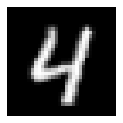

In [ ]:
sample_digit4_data = next(iter(dataset_digit4))
plt.figure(figsize=(2, 2))
plt.imshow(sample_digit4_data[0].numpy()[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

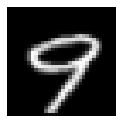

In [ ]:
sample_digit9_data = next(iter(dataset_digit9))
plt.figure(figsize=(2, 2))
plt.imshow(sample_digit9_data[0].numpy()[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

## Model Building
1. Instance Normalization
2. Downsampling , Upsampling and Unet
3. Generator building using Unet
4. Discriminator Building

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self,epsilon=1e-5):
    super(InstanceNormalization,self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape= input_shape[-1:],
        initializer= tf.random_normal_initializer(1.,0.02),
        trainable= True
      )

    self.offset= self.add_weight(
        name='offset',
        shape= input_shape[-1:],
        initializer='zeros',
        trainable= True
      )

  def call(self,x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)

    inv = tf.math.rsqrt(variance + self.epsilon)

    normalized = (x - mean) * inv

    return self.scale*normalized +self.offset




### Downsampling

In [ ]:
def down_sample(filters, size, apply_norm=True):
  initializer= tf.random_normal_initializer(0.,0.02)
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=size, strides= 2, padding='same', 
                                   kernel_initializer=initializer, use_bias=False))
  
  if apply_norm:
    model.add(InstanceNormalization())

  model.add(tf.keras.layers.LeakyReLU())

  return model

# Upsampling

In [ ]:
def up_sample(filters, size, apply_norm=True, apply_dropout=False):
  initializer= tf.random_normal_initializer(0.,0.02)
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=size, strides= 2, padding='same', 
                                   kernel_initializer=initializer, use_bias=False))
  
  if apply_norm:
    model.add(InstanceNormalization())

  if apply_dropout:
    model.add(tf.keras.layers.Dropout(rate=0.5))

  model.add(tf.keras.layers.ReLU())

  return model

## Constructing Unet

In [ ]:
def unet_generator():
    down_stack = [
        down_sample(64, 4, False), # (bs, 16, 16, 64)
        down_sample(128, 4), # (bs, 8, 8, 128)
        down_sample(128, 4), # (bs, 4, 4, 128)
        down_sample(128, 4), # (bs, 2, 2, 128)
        down_sample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        up_sample(128, 4, True), # (bs, 2, 2, 256)
        up_sample(128, 4, True), # (bs, 4, 4, 256)
        up_sample(128, 4), # (bs, 8, 8, 256)
        up_sample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[32, 32, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

## Generator for X and Y images 

In [ ]:
generator_g = unet_generator()
generator_f= unet_generator()

In [ ]:
generator_f.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16, 16, 64)   1024        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 8, 8, 128)    131328      sequential_9[0][0]               
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 4, 4, 128)    262400      sequential_10[0][0]              
____________________________________________________________________________________________

In [ ]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 64)   1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8, 8, 128)    131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 4, 128)    262400      sequential_1[0][0]               
______________________________________________________________________________________________

### Discriminator

In [ ]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = down_sample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = down_sample(128, 4)(down1) # (bs, 8, 8, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
discriminator_x = discriminator()

discriminator_y = discriminator()



In [ ]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 16, 16, 64)        1024      
_________________________________________________________________
sequential_19 (Sequential)   (None, 8, 8, 128)         131328    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 256)         524288    
_________________________________________________________________
instance_normalization_17 (I (None, 7, 7, 256)         512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 256)         0   

In [ ]:
discriminator_y.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
sequential_20 (Sequential)   (None, 16, 16, 64)        1024      
_________________________________________________________________
sequential_21 (Sequential)   (None, 8, 8, 128)         131328    
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 256)         524288    
_________________________________________________________________
instance_normalization_19 (I (None, 7, 7, 256)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 256)         0   

### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

Check output of Untrained Generator models which should be a random noise

In [ ]:
to_digit9_data= generator_g(sample_digit9_data)
to_digit4_data= generator_g(sample_digit4_data)

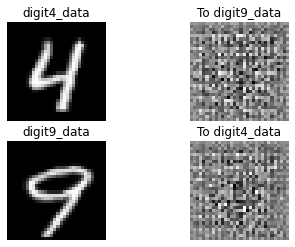

In [ ]:
imgs = [sample_digit4_data, to_digit9_data, sample_digit9_data, to_digit4_data]
title = ['digit4_data', 'To digit9_data', 'digit9_data', 'To digit4_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since Our Discriminator is a classifier

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  fake_loss = loss_obj(tf.zeros_like(generated), generated)

  total_loss = real_loss + fake_loss

  return total_loss *0.5 # mean of the loss

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data


In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

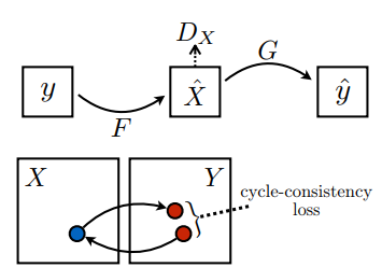

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return cycle_loss * 10.0

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

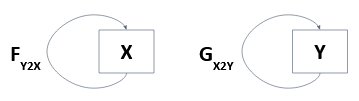

In [ ]:
def identity_loss(real_image, same_image):
  identity_loss = tf.reduce_mean(tf.abs(real_image - same_image))

  return identity_loss * 0.5


#### Optimizer 
We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We'll train out Model for 100 Epochs

In [ ]:
EPOCHS=100

#### Checkpoint Initialization
Initialize checkpoints to save models

In [ ]:
checkpoint_path = '/content/drive/MyDrive/app/gan/cyclegan/Training1'

chck_pnt = tf.train.Checkpoint(generator_g= generator_g,
                               generator_f= generator_f,
                               discriminator_x=discriminator_x,
                               discriminator_y= discriminator_y,
                               generator_g_optimizer=generator_g_optimizer,
                               generator_f_optimizer=generator_f_optimizer,
                               discriminator_x_optimizer=discriminator_x_optimizer,
                               discriminator_y_optimizer=discriminator_y_optimizer
                               )

chck_pnt_mgr = tf.train.CheckpointManager(chck_pnt, checkpoint_path,max_to_keep=3)

if chck_pnt_mgr.latest_checkpoint:
  chck_pnt.restore(chck_pnt_mgr.latest_checkpoint)
  print('Latest Checkpoint restored')



Function to show Images output by Generators while Training

In [ ]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

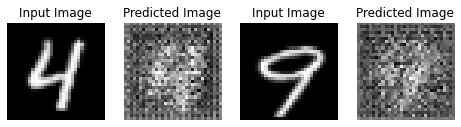

Saving checkpoint for epoch 1 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-1


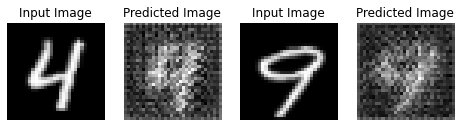

Saving checkpoint for epoch 2 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-2


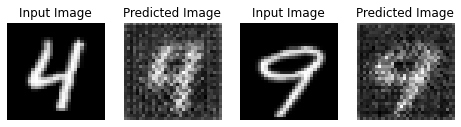

Saving checkpoint for epoch 3 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-3


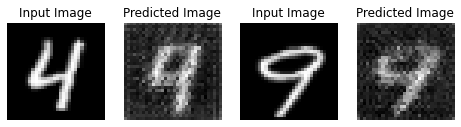

Saving checkpoint for epoch 4 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-4


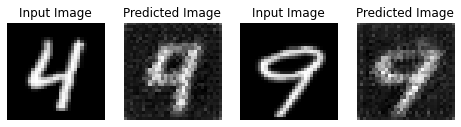

Saving checkpoint for epoch 5 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-5


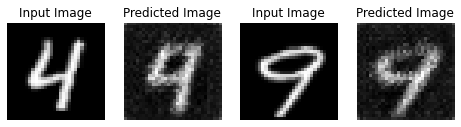

Saving checkpoint for epoch 6 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-6


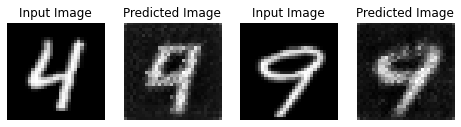

Saving checkpoint for epoch 7 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-7


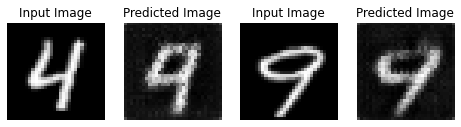

Saving checkpoint for epoch 8 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-8


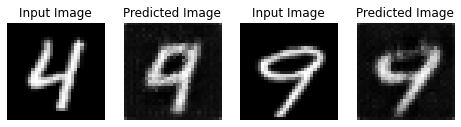

Saving checkpoint for epoch 9 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-9


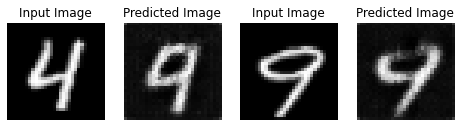

Saving checkpoint for epoch 10 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-10


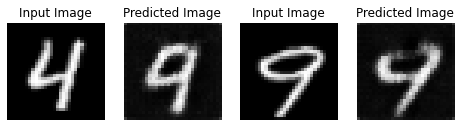

Saving checkpoint for epoch 11 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-11


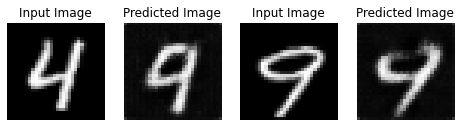

Saving checkpoint for epoch 12 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-12


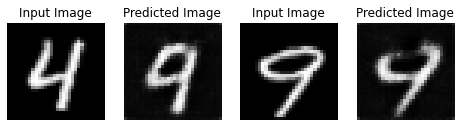

Saving checkpoint for epoch 13 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-13


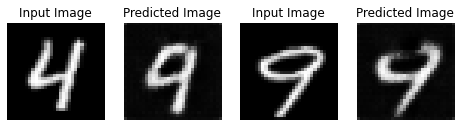

Saving checkpoint for epoch 14 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-14


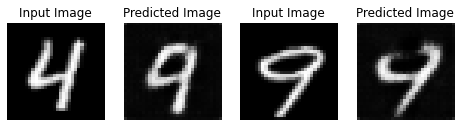

Saving checkpoint for epoch 15 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-15


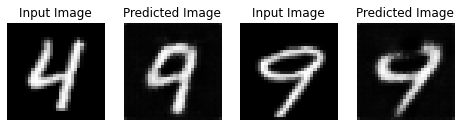

Saving checkpoint for epoch 16 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-16


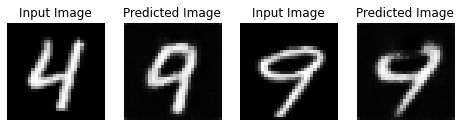

Saving checkpoint for epoch 17 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-17


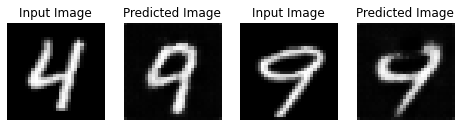

Saving checkpoint for epoch 18 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-18


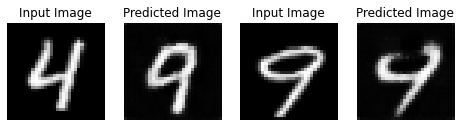

Saving checkpoint for epoch 19 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-19


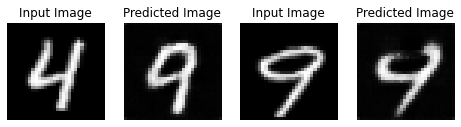

Saving checkpoint for epoch 20 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-20


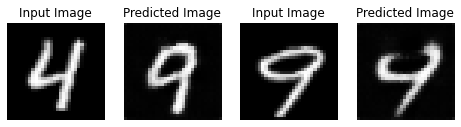

Saving checkpoint for epoch 21 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-21


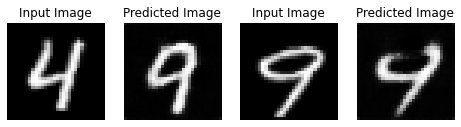

Saving checkpoint for epoch 22 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-22


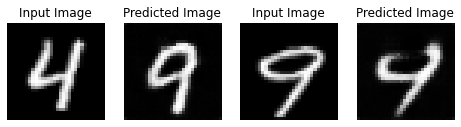

Saving checkpoint for epoch 23 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-23


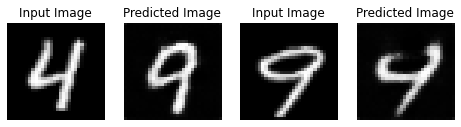

Saving checkpoint for epoch 24 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-24


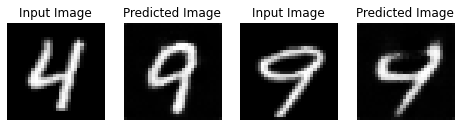

Saving checkpoint for epoch 25 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-25


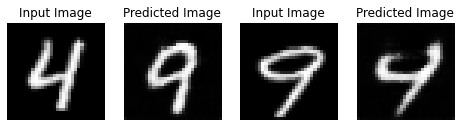

Saving checkpoint for epoch 26 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-26


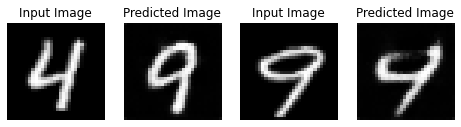

Saving checkpoint for epoch 27 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-27


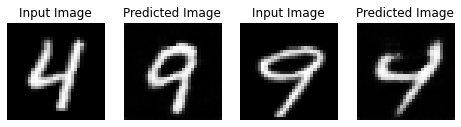

Saving checkpoint for epoch 28 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-28


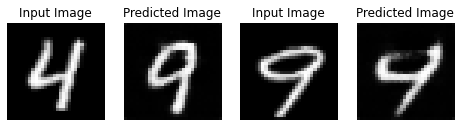

Saving checkpoint for epoch 29 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-29


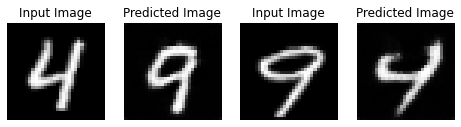

Saving checkpoint for epoch 30 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-30


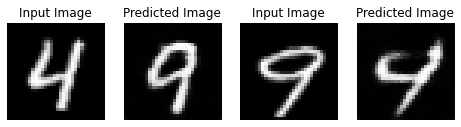

Saving checkpoint for epoch 31 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-31


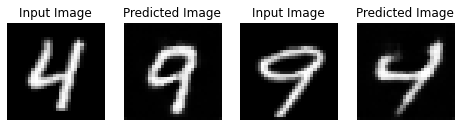

Saving checkpoint for epoch 32 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-32


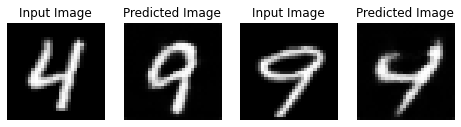

Saving checkpoint for epoch 33 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-33


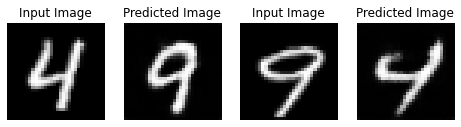

Saving checkpoint for epoch 34 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-34


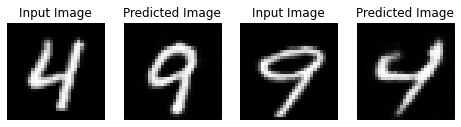

Saving checkpoint for epoch 35 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-35


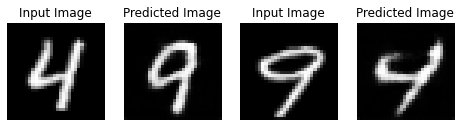

Saving checkpoint for epoch 36 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-36


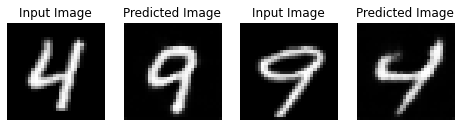

Saving checkpoint for epoch 37 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-37


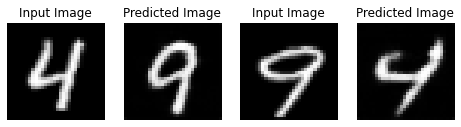

Saving checkpoint for epoch 38 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-38


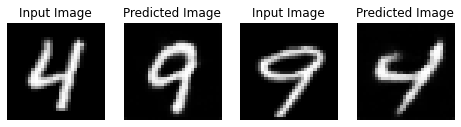

Saving checkpoint for epoch 39 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-39


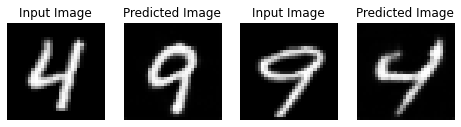

Saving checkpoint for epoch 40 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-40


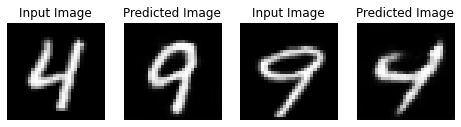

Saving checkpoint for epoch 41 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-41


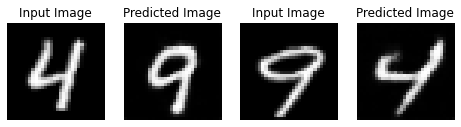

Saving checkpoint for epoch 42 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-42


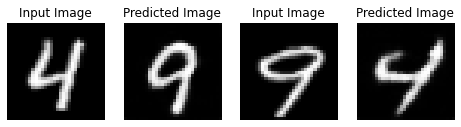

Saving checkpoint for epoch 43 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-43


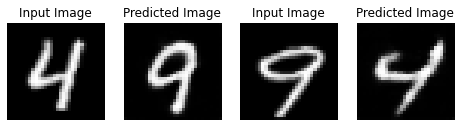

Saving checkpoint for epoch 44 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-44


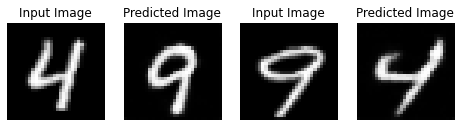

Saving checkpoint for epoch 45 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-45


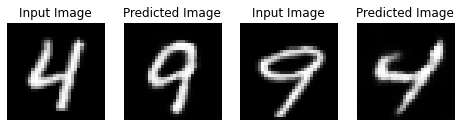

Saving checkpoint for epoch 46 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-46


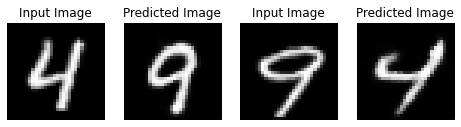

Saving checkpoint for epoch 47 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-47


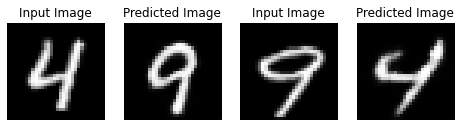

Saving checkpoint for epoch 48 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-48


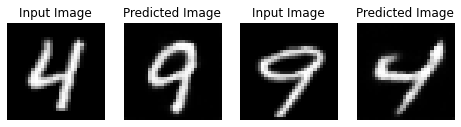

Saving checkpoint for epoch 49 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-49


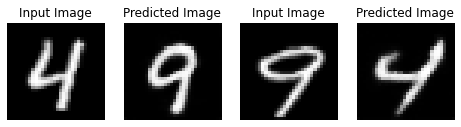

Saving checkpoint for epoch 50 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-50


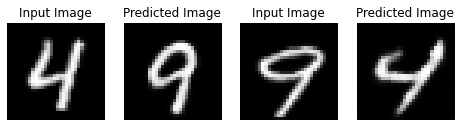

Saving checkpoint for epoch 51 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-51


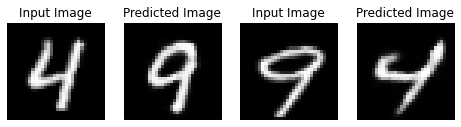

Saving checkpoint for epoch 52 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-52


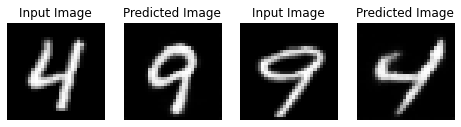

Saving checkpoint for epoch 53 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-53


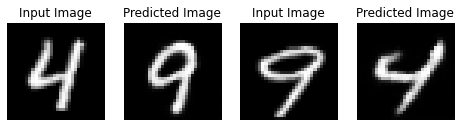

Saving checkpoint for epoch 54 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-54


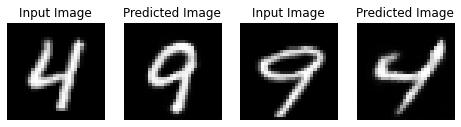

Saving checkpoint for epoch 55 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-55


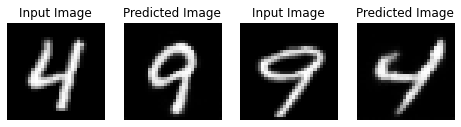

Saving checkpoint for epoch 56 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-56


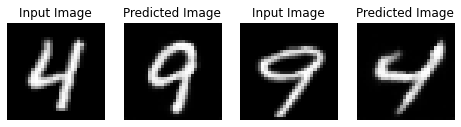

Saving checkpoint for epoch 57 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-57


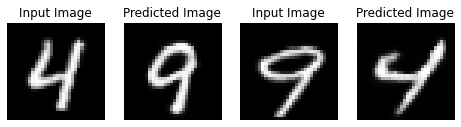

Saving checkpoint for epoch 58 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-58


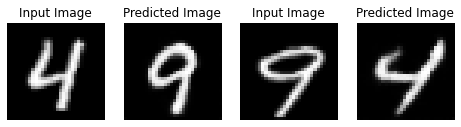

Saving checkpoint for epoch 59 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-59


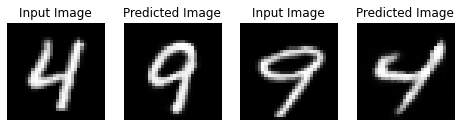

Saving checkpoint for epoch 60 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-60


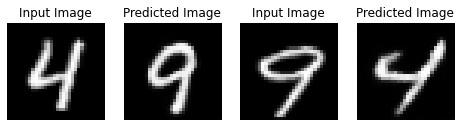

Saving checkpoint for epoch 61 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-61


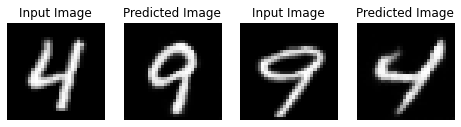

Saving checkpoint for epoch 62 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-62


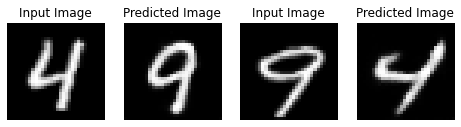

Saving checkpoint for epoch 63 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-63


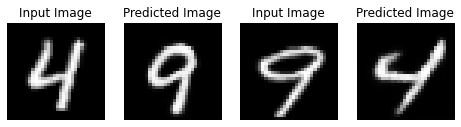

Saving checkpoint for epoch 64 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-64


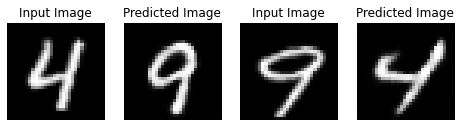

Saving checkpoint for epoch 65 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-65


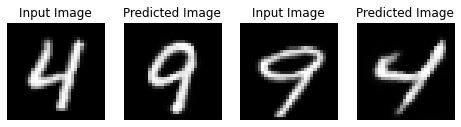

Saving checkpoint for epoch 66 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-66


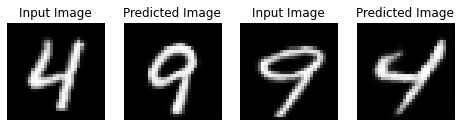

Saving checkpoint for epoch 67 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-67


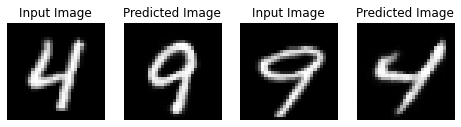

Saving checkpoint for epoch 68 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-68


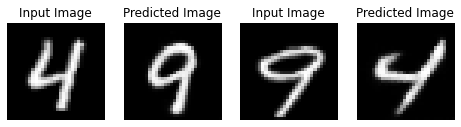

Saving checkpoint for epoch 69 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-69


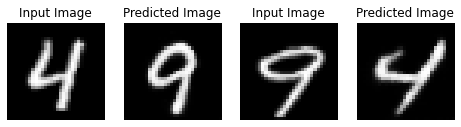

Saving checkpoint for epoch 70 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-70


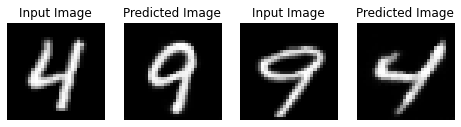

Saving checkpoint for epoch 71 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-71


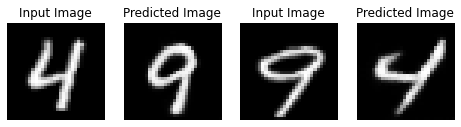

Saving checkpoint for epoch 72 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-72


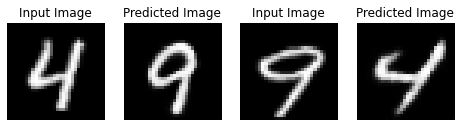

Saving checkpoint for epoch 73 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-73


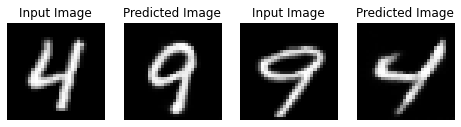

Saving checkpoint for epoch 74 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-74


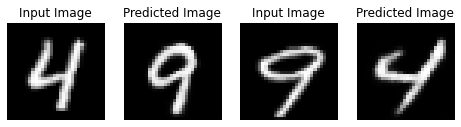

Saving checkpoint for epoch 75 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-75


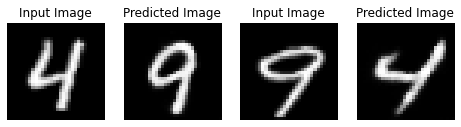

Saving checkpoint for epoch 76 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-76


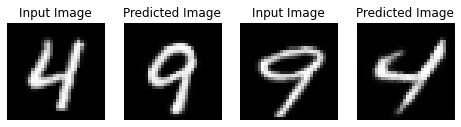

Saving checkpoint for epoch 77 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-77


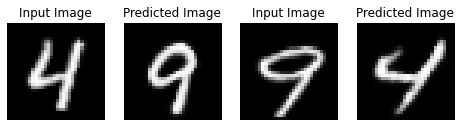

Saving checkpoint for epoch 78 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-78


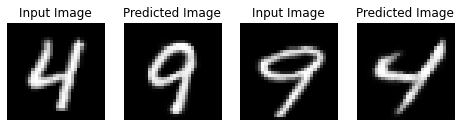

Saving checkpoint for epoch 79 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-79


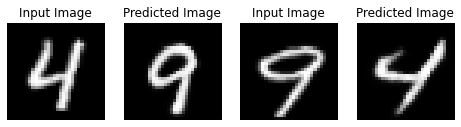

Saving checkpoint for epoch 80 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-80


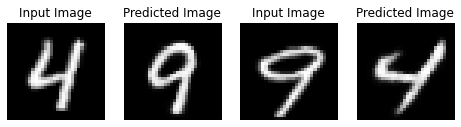

Saving checkpoint for epoch 81 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-81


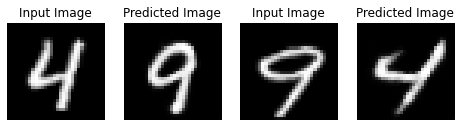

Saving checkpoint for epoch 82 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-82


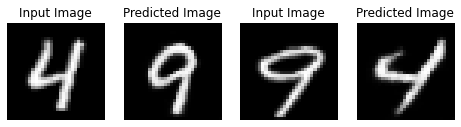

Saving checkpoint for epoch 83 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-83


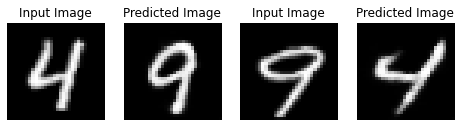

Saving checkpoint for epoch 84 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-84


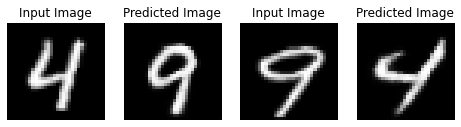

Saving checkpoint for epoch 85 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-85


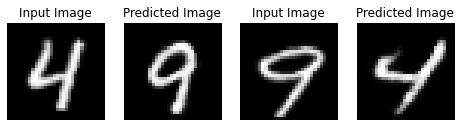

Saving checkpoint for epoch 86 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-86


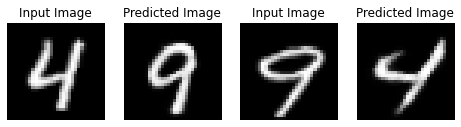

Saving checkpoint for epoch 87 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-87


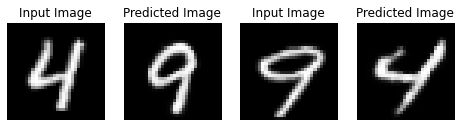

Saving checkpoint for epoch 88 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-88


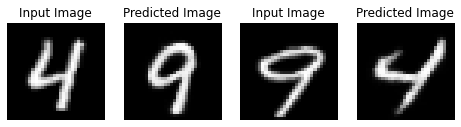

Saving checkpoint for epoch 89 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-89


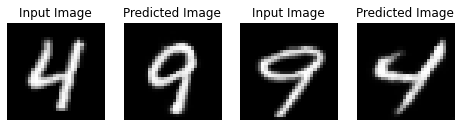

Saving checkpoint for epoch 90 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-90


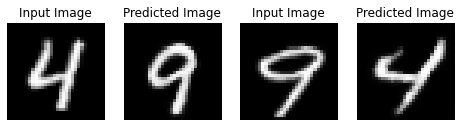

Saving checkpoint for epoch 91 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-91


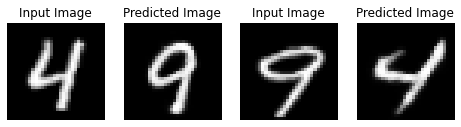

Saving checkpoint for epoch 92 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-92


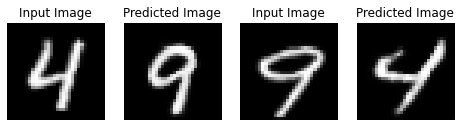

Saving checkpoint for epoch 93 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-93


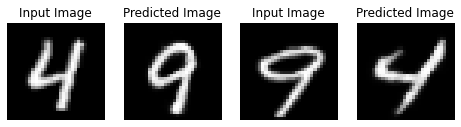

Saving checkpoint for epoch 94 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-94


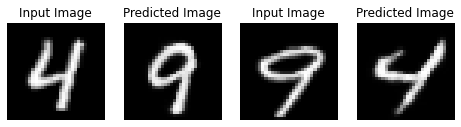

Saving checkpoint for epoch 95 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-95


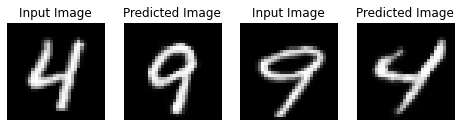

Saving checkpoint for epoch 96 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-96


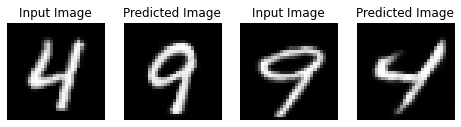

Saving checkpoint for epoch 97 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-97


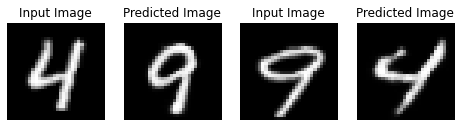

Saving checkpoint for epoch 98 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-98


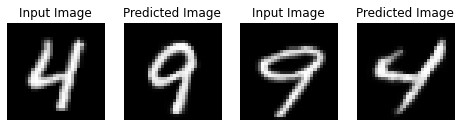

Saving checkpoint for epoch 99 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-99


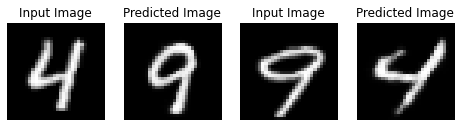

Saving checkpoint for epoch 100 at /content/drive/MyDrive/app/gan/cyclegan/Training1/ckpt-100


In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((dataset_digit4, dataset_digit9)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_digit4_data, generator_f, sample_digit9_data)
    ckpt_save_path = chck_pnt_mgr.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF for visualization of Results
Notice the Quality of results we are getting.

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0t8_ud2k
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0t8_ud2k
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.02b3cacb3742ac64d4a0b20e3f8d19bf62cf47730_-py3-none-any.whl size=154265 sha256=88b212f4e7b2c24657e4468393494fdfd21b6dc0543e3422359ca286a70347bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kuwcnj7/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.



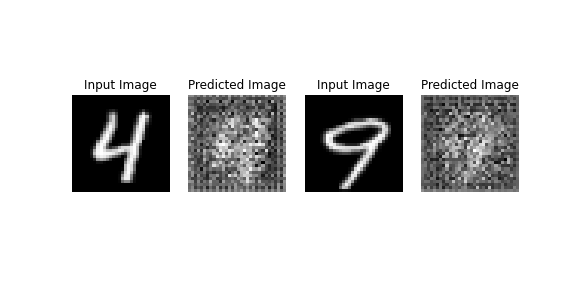

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)